In [1]:
import pandas as pd
import numpy as np
import pygraphviz

In [2]:
def gen_graph(df, penwidth=15, k="1.0", r="0.5"):
    A = pygraphviz.AGraph(strict=False)
    A.graph_attr["overlap"] = "prism1000"
    A.graph_attr["splines"] = "true"
    A.graph_attr["bgcolor"] = "#ffffff"
    A.graph_attr["outputorder"] = "edgesfirst"
    A.graph_attr["sep"] = "+20,20"
    A.graph_attr["esep"] = "+15,15"
    A.graph_attr["K"] = k
    A.graph_attr["repulsiveforce"] = r
    ew = dict()

    for g in df.index:
        z = df.loc[g]
        for c in (z[z > 0]).index:
            ekey = tuple(sorted([g, c]))
            ew[ekey] = df.loc[g, c]
            A.add_edge(g, c, weight=df.loc[g, c], style="filled")

    v = ew.values()
    mn = min(v)
    mx = max(v)
    d = mx - mn

    if d == 0:
        d = 1

    for k, v in ew.items():
        e = A.get_edge(*k)
        pw = ((float(v) - mn) / d)
        e.attr["penwidth"] = pw * penwidth + 2.0

    return A

### Read in the data files

In [3]:
df = pd.read_table("adj_matrix.tsv", sep="\t", index_col=0, header=0)
cstable = pd.read_table("cstable.txt", sep="\t", index_col=0, header=0)

### Remove any spaces that crept into the cstable index

In [4]:
newidx = [i.replace(" ", "") for i in cstable.index.tolist()]
cstable.index = newidx

### Scale the center node sizes

In [5]:
scale_lo = 1
scale_hi = 2

mn = cstable.Size.min()
mx = cstable.Size.max()

c = scale_hi - scale_lo
cstable["nsize"] = c * (cstable.Size - mn) / (mx - mn) + 1.0

### Only use motifs (nodes) with score greater than 2.0 (-log10 pval)

In [6]:
df.where(df > 2.0, 0.0, inplace=True)

### Build the center node list off of the motif filter results

In [7]:
z = df.any()
centers = z[z].index.tolist()

### Center node color map

In [8]:
rmap = ['#ff8c00', '#5ca904', '#ffa500', '#1e90ff', '#0652ff', '#6b8ba4', '#006400', '#c875c4', '#ff0000', '#0000ff', '#014d4e', '#15b01a', '#be0119', '#cf6275', '#580f41', '#7f2b0a', '#a83c09', '#7f5e00', '#030aa7', '#800080', '#029386']

### Build the graph

In [9]:
A = gen_graph(df, penwidth=10, k="0.75", r="1.0")

### Set some default node attributes

In [10]:
for n in A.nodes():
    n.attr["style"] = "filled"
    n.attr["fillcolor"] = "#ffffc2"
    n.attr["fontname"] = "sans serif bold"
    n.attr["fontsize"] = "16"

### Set the center node sizes based upon cluster sizes

In [11]:
for i in cstable.index.tolist():
    if i in A:
        n = A.get_node(i)
        c = cstable.loc[i].nsize
        w = 1.25 * c
        h = 1.25 * c
        n.attr["width"] = str(w)
        n.attr["height"] = str(h)
        n.attr["fontname"] = "sans serif bold"
        n.attr["fontsize"] = "48"

### Modify the Ubiquitous node label to make the node round

In [12]:
n = A.get_node("Ubiquitous")
n.attr["fontsize"] = 32
n.attr["label"] = "Ubiqui-\ntous"

### Set the center node edge colors and use the first color in the map for the Ubiquitous node edges

In [13]:
i = 1
for j in sorted(centers[:-1], key=int):
    if j in A:
        for e in A.edges(j):
            e.attr["color"] = rmap[i]
        i += 1

for e in A.edges("Ubiquitous"):
    e.attr["color"] = rmap[0]

### Fill the nodes belonging to two or more clusters with mauve and increase the outline thickness

In [15]:
for n in A.nodes():
    if n not in centers:
        if len(A[n]) > 1:
            n.attr["style"] = "filled"
            n.attr["fillcolor"] = "#e0d0d0"
            n.attr["penwidth"] = "3"

### Fill each center node with the same color as its edges

In [16]:
for c in centers:
    e = A.edges(c)[0]
    hc = e.attr["color"]
    n = A.get_node(c)
    n.attr["style"] = "filled"
    n.attr["fillcolor"] = "{0}90".format(hc)

### Fix-up long node labels to make the shape not so oblong

In [17]:
n = A.get_node("ENSMUSG00000044690")
n.attr["label"] = "ENSMUSG-\n00000044690"
n.attr["width"] = 1.25

n = A.get_node("9430076C15Rik")
n.attr["label"] = "9430076-\nC15Rik"
n.attr["width"] = 1.25

n = A.get_node("IRC900814")
n.attr["label"] = "IRC90-\n0814"
n.attr["width"] = 1.25

### Layout using SFDP (Scaleable Force-Directed) algorithm

In [19]:
A.layout(prog="sfdp")

### For illustrative purpose, display in notebook with Matplotlib

In [20]:
import io
import matplotlib.pyplot as plt
import scipy.ndimage

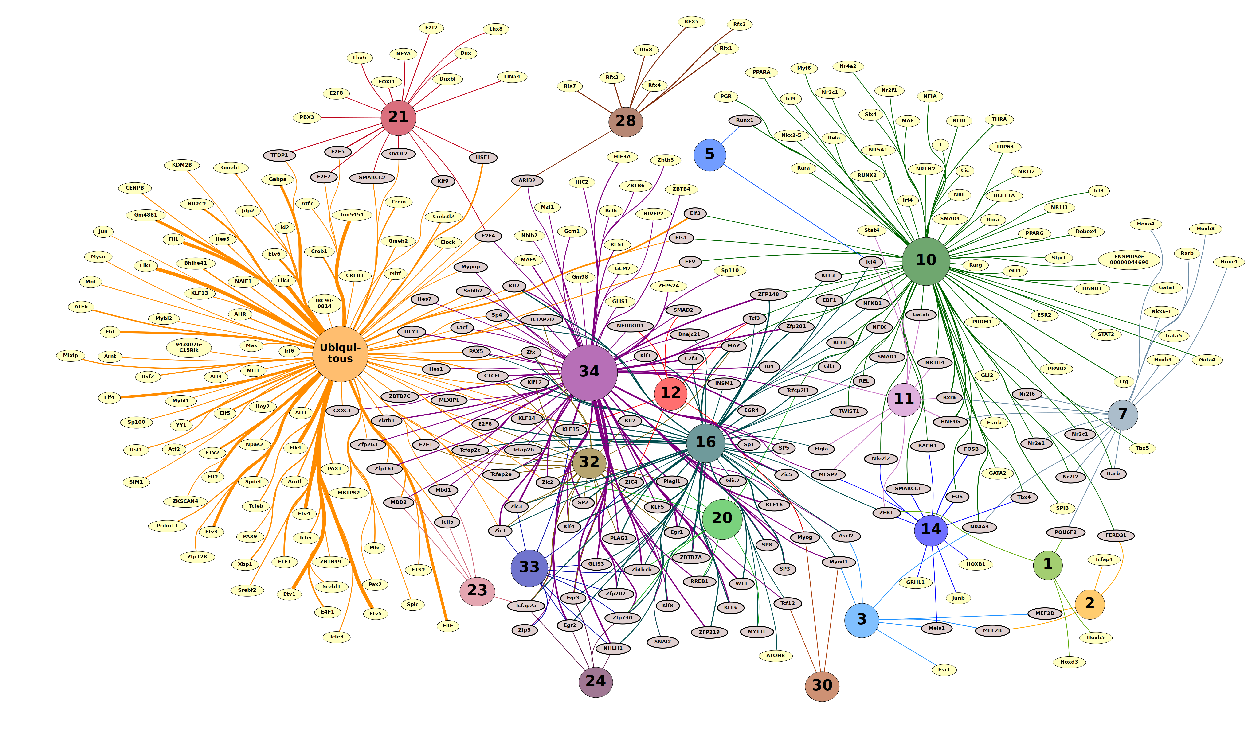

In [22]:
%matplotlib inline

bio = io.BytesIO()
A.draw(bio, format="png")
bio.seek(0)

img = scipy.ndimage.imread(bio)

fig = plt.figure(figsize=(15.36, 10.24), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, interpolation="nearest")
ax.set_axis_off()

bio.close()